In [24]:
# dependencies
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch import optim 
from torchvision.datasets import ImageFolder
from torchvision import transforms as tvt
from PIL import Image
from matplotlib import pyplot as plt

#  for mac, PC users need change to 'cuda' if they have discrete GPU, else 'cpu'
device = 'mps'

In [2]:
# intemediate layers of CNN, sandwhiched between input and output
# CNN, BATCH NORM, RELU
class intermediate(nn.Module):
  def __init__(self, K = 3, S = 1, P = 1, F = 16):
    super(intermediate, self).__init__()
    chain = [None] * 3
    chain[0] = nn.Conv2d(in_channels = F, out_channels = F, kernel_size = K, stride = S, padding = P)
    chain[1] = nn.BatchNorm2d(F)
    chain[2] =  nn.ReLU(inplace = True)
    self.trans = nn.Sequential(*chain)
  def forward(self, inp):
    return self.trans(inp)


# create the model
# a chain of 10 intermiediate layers, one input CNN, one output CNN
# CNNs maintain spatial dimensions. Only chainge number of channels
# Input has 1 greyscale channel, output has 1 greyscale channel
# all intermediate layers have same number of channels
class DENOISER(nn.Module):
  def __init__(self, layers = 10):
    super(DENOISER, self).__init__()
    chain = []
    K, S, P, F = 3, 1, 1, 16
    chain.append(nn.Conv2d(in_channels = 1, out_channels = F, kernel_size = K, stride = S, padding = P))
    chain.append(nn.ReLU(inplace = True))
    for i in range(layers): chain.append(intermediate(K = K, S = S, P = P, F = F))
    chain.append(nn.Conv2d(in_channels = F, out_channels = 1, kernel_size = K, stride = S, padding = P))
    self.trans = nn.Sequential(*chain)
  def forward(self, inp):
    return self.trans(inp) - inp

In [3]:
# hyperparameters
# changed based on expirementationss
net = DENOISER().to(device)
num_epochs =  5
lr = 1e-3
batch_size = 4
opt = optim.Adam(net.parameters(), lr = lr)
criterion = nn.MSELoss(size_average = False)
noiselvl = 30
alpha = 0.5

/Users/ilanbenschikovski/anaconda3/envs/kak/lib/python3.12/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [7]:
# create toy dataloader
# comes from COCO dataset by Microsoft
uniform_transform = tvt.Compose([tvt.Grayscale(), tvt.Resize((300, 300)), tvt.ToTensor()])
dataset = ImageFolder(root = 'coco_samples_train', transform = uniform_transform)
dataloader = DataLoader(dataset, batch_size = batch_size, shuffle = True)

In [8]:
# based off paper explanation of math
for epoch in range(1, num_epochs + 1):
  for idx, (data, _), in enumerate(dataloader):
    raw = data.to(device)
    net.train()
    net.zero_grad()
    opt.zero_grad()
    sigma_norm = noiselvl / 255 # max pixel val
    noise = (torch.randn(raw.shape) * sigma_norm).to(device)

    subnoise = raw - noise / alpha
    addnoise = raw + noise * alpha

    out = net(subnoise)
    loss = criterion(out, addnoise)
    if (idx % 10 == 0): print(f"epoch, index, loss: {epoch}, {idx}, {loss}")
    loss.backward()
    opt.step()
    net.eval()


epoch, index, loss: 1, 0, 22280.54296875
epoch, index, loss: 1, 10, 24243.99609375
epoch, index, loss: 2, 0, 49005.85546875
epoch, index, loss: 2, 10, 26146.21875
epoch, index, loss: 3, 0, 24363.255859375
epoch, index, loss: 3, 10, 19929.3515625
epoch, index, loss: 4, 0, 14422.4892578125
epoch, index, loss: 4, 10, 20713.37109375
epoch, index, loss: 5, 0, 24875.11328125
epoch, index, loss: 5, 10, 28523.751953125


In [9]:
# create toy dataloader for testing
uniform_transform = tvt.Compose([tvt.Grayscale(), tvt.Resize((300, 300)), tvt.ToTensor()])
dataset = ImageFolder(root = 'coco_samples_test', transform = uniform_transform)
dataloader = DataLoader(dataset, batch_size = batch_size, shuffle = True)

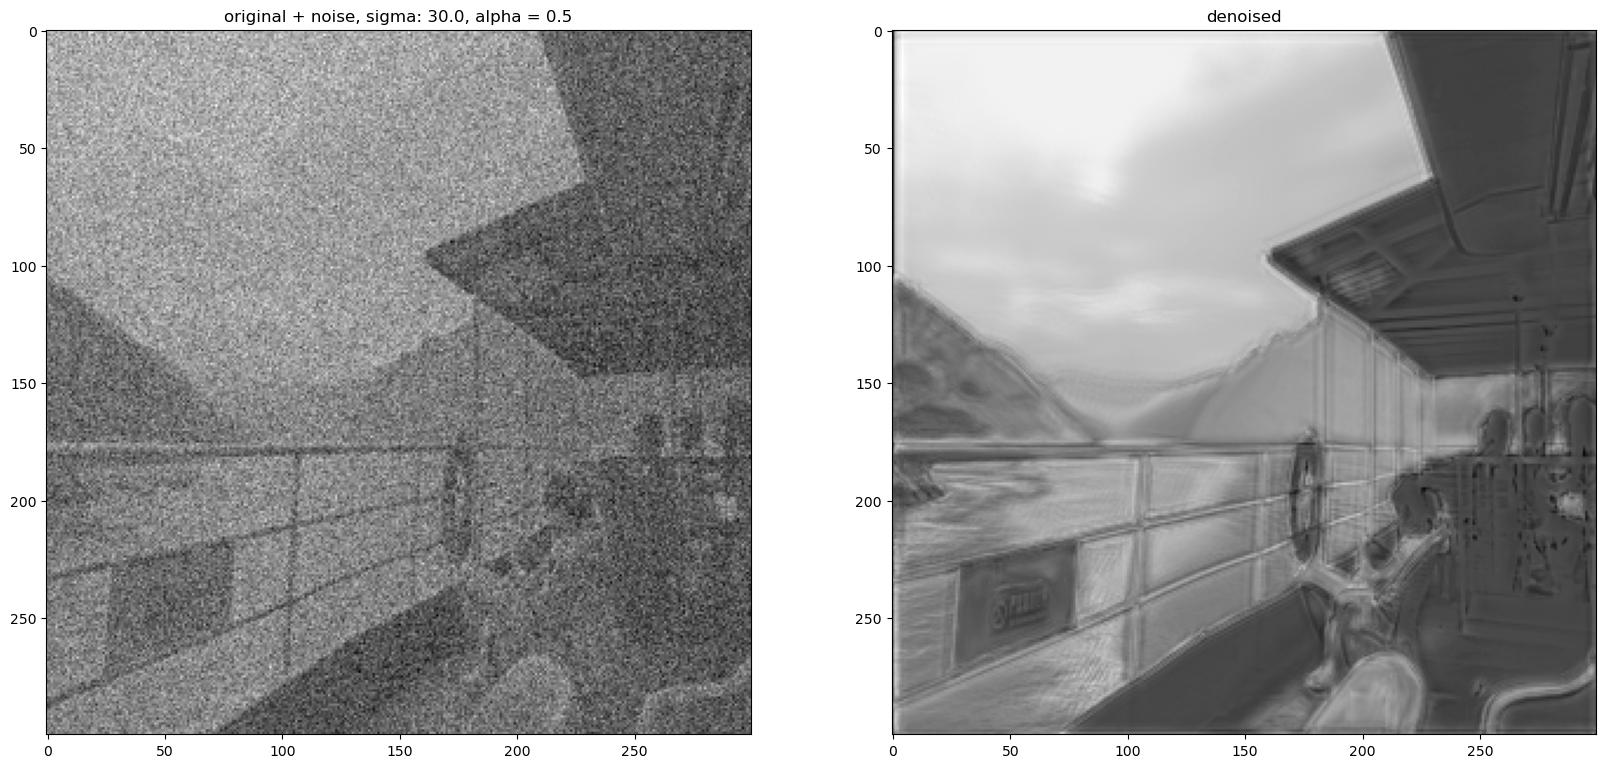

In [25]:
# show effect on random image in testing data
for idx, (data, _), in enumerate(dataloader):
  data = data.to(device)
  noise = (torch.randn(raw.shape) * sigma_norm).to(device)
  subnoise = data - noise / alpha
  out = net(data).to('cpu').detach()
  fig = plt.figure(figsize = (20,50))
  plt.subplot(1,2,1)
  plt.title(f'original + noise, sigma: {sigma_norm * 255}, alpha = {alpha}')
  plt.imshow(subnoise.to('cpu')[0].permute(1,2,0), cmap = 'gray')
  plt.subplot(1,2,2)
  plt.imshow(out[0].permute(1,2,0), cmap = 'gray')
  plt.title("denoised")
  break